# Training with Data Augmentation

### Author: Xuying Ning
### All copyright reserved.

In [1]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import os
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from facenet_pytorch import InceptionResnetV1
from torch import optim
from facenet_pytorch import fixed_image_standardization, training
from torch.utils.data import DataLoader

In [95]:
os.mkdir('crop-mask-aug')
os.mkdir('crop-mask-aug/train')

In [4]:
orig_img = cv2.imread('crop-mask-face/test/Alejandro_Toledo_0007.jpg')
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

In [7]:
type(orig_img)

numpy.ndarray

In [8]:
orig_img = Image.fromarray(orig_img)

In [5]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

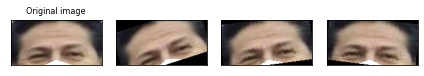

In [10]:
import torchvision.transforms as T
rotater = T.RandomRotation(degrees=(-20,20))
rotated_imgs = [rotater(orig_img) for _ in range(3)]
# row_title = [str(policy).split('.')[-1] for policy in policies]
plot(rotated_imgs)

In [101]:
train_list = os.listdir('crop-mask-face/train/')

In [102]:
train_list = [item for item in train_list if '.jpg' in item ]

In [103]:
train_dst = []

In [104]:
for img_name in train_list:
    orig_img = cv2.imread(os.path.join('crop-mask-face/train/',img_name))
    # orig_img = cv2.equalizeHist(orig_img)
    orig_img = Image.fromarray(orig_img)
    # orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    imgs = [orig_img]+[rotater(orig_img) for _ in range(3)]
    # print(imgs)
    for i in range(4):
        dst = 'aug'+str(i)+'_'+img_name
        train_dst.append(dst)
        cv2.imwrite(os.path.join('crop-mask-aug/train',dst),np.asarray(imgs[i]))

In [105]:
len(train_dst)

5360

In [106]:
names = pd.read_csv('target_names.csv',index_col = 0)

In [107]:
labels_new = []
for item in train_dst:
    for name in names['0']:
        if name in item:
            labels_new.append(int(names[names['0']==name].index.values))
train_new = {'train_file': train_dst,'labels': labels_new }
train_new = pd.DataFrame(train_new)

In [108]:
train_new.to_csv('train_new.csv',index = False)

In [7]:
class CustomImageDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=ToTensor()):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dira (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        # image = image.view((224,224,3))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.equalizeHist(image)
        image = Image.fromarray(image)
        # print(type(image))
        # # image = np.transpose(image,(1,2,0)) 
        label = self.landmarks_frame.iloc[idx, 1]
        label = np.array(label)
        if self.transform:
            image = self.transform(image)
        return image,label

In [9]:
from facenet_pytorch import fixed_image_standardization, training
preprocessing = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    transforms.Resize((160,160)),
    fixed_image_standardization
])

trainset = CustomImageDataset(csv_file = 'train_new.csv',
                              root_dir='crop-mask-aug/train/',
                             transform = preprocessing)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 160, 160])
1 torch.Size([3, 160, 160])
2 torch.Size([3, 160, 160])
3 torch.Size([3, 160, 160])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


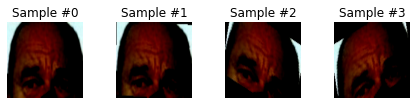

In [6]:
for i in range(len(trainset)):
    data,label = trainset[i]

    print(i, data.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(data.permute(1,2,0),cmap = plt.cm.gray)
    if i == 3:
        plt.show()
        break

In [7]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=8,
                        shuffle=True, num_workers=0)

In [10]:
testset = CustomImageDataset(csv_file = 'test.csv',
                              root_dir='crop-mask-face/test/',
                             transform = preprocessing)
testloader = DataLoader(testset, batch_size=8,
                        shuffle=True, num_workers=0)
valset = CustomImageDataset(csv_file = 'val.csv',
                              root_dir='crop-mask-face/val/',
                             transform = preprocessing)
valloader = DataLoader(valset, batch_size=8,
                        shuffle=True, num_workers=0)

In [9]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from facenet_pytorch import InceptionResnetV1
from torch import optim
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes= 50
).to(device)
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [10]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir = 'tf-logs' )
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
epochs = 35
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, valloader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)
ls_i = 1e10

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, trainloader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    ls,mc = training.pass_epoch(
        resnet, loss_fn, valloader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    if ls < ls_i:
        torch.save(resnet.state_dict(),'model_parameter1.pth')
        ls_i = ls
        print('! Save Model of', epoch, 'Epoch !')

writer.close()



Initial
----------
Valid |    21/21   | loss:    3.9367 | fps:   91.4612 | acc:    0.0377   

Epoch 1/35
----------
Train |   670/670  | loss:    2.9918 | fps:   76.4620 | acc:    0.2293   
Valid |    21/21   | loss:    1.9205 | fps:  111.8854 | acc:    0.4821   
! Save Model of 0 Epoch !

Epoch 2/35
----------
Train |   670/670  | loss:    1.8488 | fps:   77.8157 | acc:    0.4726   
Valid |    21/21   | loss:    1.4807 | fps:  104.0110 | acc:    0.6151   
! Save Model of 1 Epoch !

Epoch 3/35
----------
Train |   670/670  | loss:    1.2620 | fps:   77.4809 | acc:    0.6397   
Valid |    21/21   | loss:    0.9448 | fps:  115.6847 | acc:    0.7520   
! Save Model of 2 Epoch !

Epoch 4/35
----------
Train |   670/670  | loss:    0.9373 | fps:   77.9314 | acc:    0.7200   
Valid |    21/21   | loss:    0.9582 | fps:  101.7423 | acc:    0.7758   

Epoch 5/35
----------
Train |   670/670  | loss:    0.6472 | fps:   76.7165 | acc:    0.8043   
Valid |    21/21   | loss:    0.7854 | fps:  1

In [11]:
resnet.eval()
correct = 0
total = 0
sample_count = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
#         print(labels)
        # calculate outputs by running images through the network
        outputs = resnet(images)
        # the class with the highest energy is what we choose as prediction
        _,predicted  = torch.max(outputs, 1)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if 0 in (predicted == labels):
            determinant = predicted == labels
            for j in range(len(determinant)):
                if determinant[j] == False:
                    print(f'False Sample {sample_count+1}: True Labels: {labels[j].item()}, Predicted:{predicted[j].item()}')
                    sample_count += 1
                    # plt.imshow(images[j].cpu().permute(1,2,0))

print(f'Accuracy of the network on the 196 test images: {100 * correct // total} %')

False Sample 1: True Labels: 4, Predicted:30
False Sample 2: True Labels: 37, Predicted:16
False Sample 3: True Labels: 6, Predicted:14
False Sample 4: True Labels: 6, Predicted:8
False Sample 5: True Labels: 47, Predicted:20
False Sample 6: True Labels: 31, Predicted:45
False Sample 7: True Labels: 15, Predicted:25
False Sample 8: True Labels: 47, Predicted:20
False Sample 9: True Labels: 33, Predicted:45
False Sample 10: True Labels: 34, Predicted:33
False Sample 11: True Labels: 5, Predicted:20
False Sample 12: True Labels: 2, Predicted:39
False Sample 13: True Labels: 13, Predicted:21
False Sample 14: True Labels: 16, Predicted:33
False Sample 15: True Labels: 33, Predicted:30
False Sample 16: True Labels: 23, Predicted:3
False Sample 17: True Labels: 37, Predicted:34
False Sample 18: True Labels: 8, Predicted:11
False Sample 19: True Labels: 28, Predicted:22
Accuracy of the network on the 196 test images: 90 %


In [17]:
#Use early stopping model
resnet.eval().load_state_dict(torch.load('model_parameter1.pth'), strict=True)
correct = 0
total = 0
sample_count = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
#         print(labels)
        # calculate outputs by running images through the network
        outputs = resnet(images)
        # the class with the highest energy is what we choose as prediction
        _,predicted  = torch.max(outputs, 1)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if 0 in (predicted == labels):
            determinant = predicted == labels
            for j in range(len(determinant)):
                if determinant[j] == False:
                    print(f'False Sample {sample_count+1}: True Labels: {labels[j].item()}, Predicted:{predicted[j].item()}')
                    sample_count += 1
                    # plt.imshow(images[j].cpu().permute(1,2,0))

print(f'Accuracy of the network on the 196 test images: {100 * correct / total} %')

False Sample 1: True Labels: 13, Predicted:21
False Sample 2: True Labels: 6, Predicted:14
False Sample 3: True Labels: 0, Predicted:45
False Sample 4: True Labels: 47, Predicted:20
False Sample 5: True Labels: 33, Predicted:45
False Sample 6: True Labels: 2, Predicted:39
False Sample 7: True Labels: 37, Predicted:39
False Sample 8: True Labels: 6, Predicted:8
False Sample 9: True Labels: 23, Predicted:3
False Sample 10: True Labels: 47, Predicted:26
False Sample 11: True Labels: 32, Predicted:34
False Sample 12: True Labels: 34, Predicted:33
False Sample 13: True Labels: 15, Predicted:25
False Sample 14: True Labels: 34, Predicted:45
False Sample 15: True Labels: 37, Predicted:30
False Sample 16: True Labels: 8, Predicted:11
False Sample 17: True Labels: 4, Predicted:30
False Sample 18: True Labels: 47, Predicted:43
False Sample 19: True Labels: 48, Predicted:42
False Sample 20: True Labels: 5, Predicted:20
False Sample 21: True Labels: 33, Predicted:30
False Sample 22: True Labels: 1

In [18]:
nb_classes = 50

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
acc_class = confusion_matrix.diag()/confusion_matrix.sum(1)

tensor([[4., 0., 0.,  ..., 0., 0., 0.],
        [0., 6., 0.,  ..., 0., 0., 0.],
        [0., 0., 2.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 4., 0.],
        [0., 0., 0.,  ..., 0., 0., 3.]])


In [19]:
conf_m = pd.DataFrame(confusion_matrix)
conf_m.to_csv('confision_matrix.csv')

In [20]:
cl = 0
bad_class  = []
for item in acc_class:
    if item < 0.5:
        bad_class.append(cl)
    cl += 1
print(bad_class)

[37, 47]


In [24]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from facenet_pytorch import InceptionResnetV1
from torch import optim
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes= 50
).to(device)

resnet.load_state_dict(torch.load('model_parameter1.pth'), strict=True)
resnet.eval()
testloader = DataLoader(testset, batch_size=1,
                        shuffle=True, num_workers=0)

right_pred_score = []
wrong_pred_score = []
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet(inputs)
        ps = torch.exp(outputs)
        _,prediction = torch.max(ps, 1)
        maxexp = np.max(ps.cpu().numpy())
        # print(maxexp)
        average = np.average(ps.cpu().numpy())
        score = maxexp/average
        if i < 5:
            print("Prediction : ", prediction, ", Score: ", score)
        if prediction == classes:
            right_pred_score.append(score)
        else:
            wrong_pred_score.append(score)

Prediction :  tensor([29], device='cuda:0') , Score:  43.822205
Prediction :  tensor([27], device='cuda:0') , Score:  45.95057
Prediction :  tensor([39], device='cuda:0') , Score:  49.650288
Prediction :  tensor([48], device='cuda:0') , Score:  38.9599
Prediction :  tensor([29], device='cuda:0') , Score:  49.947044


In [30]:
print(np.percentile(wrong_pred_score,50))
print(np.percentile(right_pred_score,50))

27.63246440887451
49.84760665893555


In [33]:
print(np.percentile(wrong_pred_score,85))
print(np.percentile(right_pred_score,15))

37.92452526092529
45.198720169067386
